## Using TomoPhantom to:
* build a 3D phantom using the existing moel
* generate analytical projection data (parallel beam) and add various inaccuracies to simulate more realistic imaging conditions
* reconstruct the data using the Fourier method (ToMoBAR package required)

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tomophantom
from tomophantom import TomoP3D
from tomophantom.qualitymetrics import QualityTools
from tomophantom.flatsgen import synth_flats

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

Building 3D phantom using TomoPhantom software


<Figure size 960x640 with 0 Axes>

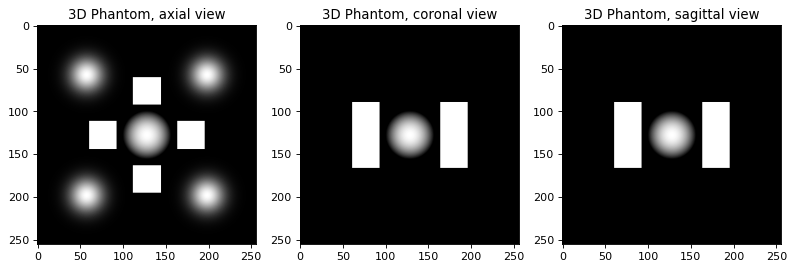

In [13]:
print ("Building 3D phantom using TomoPhantom software")
model = 9 # select a model number from the library
N_size = 256 # Define phantom dimensions using a scalar value (cubic phantom)
path = os.path.dirname(tomophantom.__file__)
path_library3D = os.path.join(path, "phantomlib", "Phantom3DLibrary.dat")
#This will generate a N_size x N_size x N_size phantom (3D)
phantom_tm = TomoP3D.Model(model, N_size, path_library3D)

sliceSel = int(0.5*N_size)
plt.gray()
plt.figure() 
plt.subplot(131)
plt.imshow(phantom_tm[sliceSel,:,:],vmin=0, vmax=1)
plt.title('3D Phantom, axial view')

plt.subplot(132)
plt.imshow(phantom_tm[:,sliceSel,:],vmin=0, vmax=1)
plt.title('3D Phantom, coronal view')

plt.subplot(133)
plt.imshow(phantom_tm[:,:,sliceSel],vmin=0, vmax=1)
plt.title('3D Phantom, sagittal view')
plt.show()

Building 3D analytical projection data with TomoPhantom


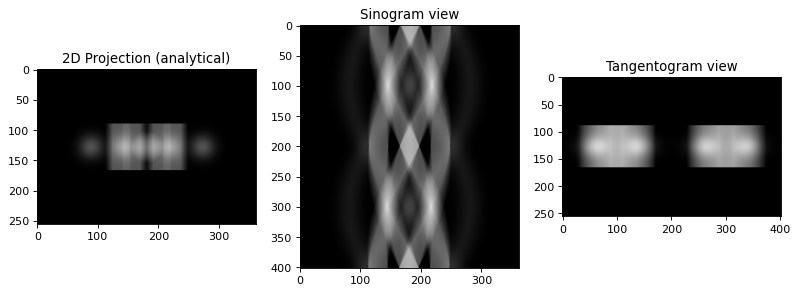

In [14]:
# 3D parallel beam projection geometry related parameters:
Horiz_det = int(np.sqrt(2)*N_size) # detector column count (horizontal)
Vert_det = N_size # detector row count (vertical) (no reason for it to be > N)
angles_num = int(0.5*np.pi*N_size); # angles number
angles = np.linspace(0.0,179.9,angles_num,dtype='float32') # in degrees
angles_rad = angles*(np.pi/180.0)
#%%
print ("Building 3D analytical projection data with TomoPhantom")
projData3D_analyt= TomoP3D.ModelSino(model, N_size, Horiz_det, Vert_det, angles, path_library3D)

intens_max_clean = np.max(projData3D_analyt)
sliceSel = 150
plt.figure() 
plt.subplot(131)
plt.imshow(projData3D_analyt[:,sliceSel,:],vmin=0, vmax=intens_max_clean)
plt.title('2D Projection (analytical)')
plt.subplot(132)
plt.imshow(projData3D_analyt[sliceSel,:,:],vmin=0, vmax=intens_max_clean)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_analyt[:,:,sliceSel],vmin=0, vmax=intens_max_clean)
plt.title('Tangentogram view')
plt.show()

Simulate synthetic flat fields, add flat field background to the projections and add noise


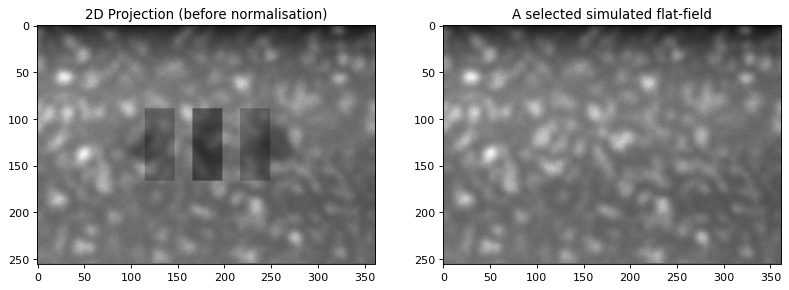

In [15]:
print ("Simulate synthetic flat fields, add flat field background to the projections and add noise")
I0  = 15000; # Source intensity
flatsnum = 20 # the number of the flat fields required

[projData3D_noisy, flatsSIM] = synth_flats(projData3D_analyt, 
                                           source_intensity = I0, source_variation=0.02,\
                                           arguments_Bessel = (1,10,10,12),\
                                           specklesize = 15,\
                                           kbar = 0.3,
                                           jitter = 1.0,
                                           sigmasmooth = 3, flatsnum=flatsnum)
del projData3D_analyt
plt.figure() 
plt.subplot(121)
plt.imshow(projData3D_noisy[:,0,:])
plt.title('2D Projection (before normalisation)')
plt.subplot(122)
plt.imshow(flatsSIM[:,0,:])
plt.title('A selected simulated flat-field')
plt.show()

Normalise projections using ToMoBAR software
____! Skimage module is required for Dynamic Flat fields estimation !____
____! Skimage module is required for Dynamic Flat fields estimation !____
____! BM3D module is required to use for dynamic flat fields calculation !____


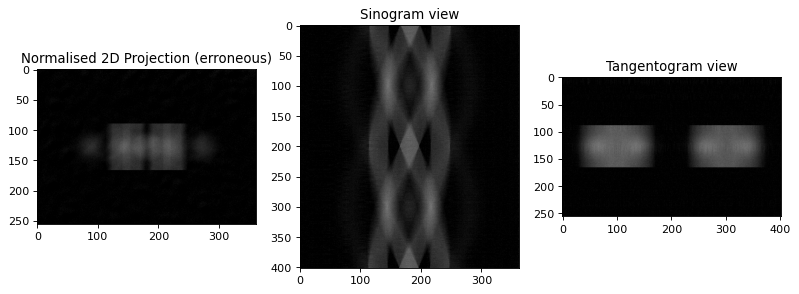

In [17]:
print ("Normalise projections using ToMoBAR software")
from tomobar.supp.suppTools import normaliser

# normalise the data, the required format is [detectorsX, Projections, detectorsY]
projData3D_norm = normaliser(projData3D_noisy, flatsSIM, darks=None, log='true', method='mean')

#del projData3D_noisy
intens_max = 0.3*np.max(projData3D_norm)
sliceSel = 150
plt.figure() 
plt.subplot(131)
plt.imshow(projData3D_norm[:,sliceSel,:],vmin=0, vmax=intens_max)
plt.title('Normalised 2D Projection (erroneous)')
plt.subplot(132)
plt.imshow(projData3D_norm[sliceSel,:,:],vmin=0, vmax=intens_max)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_norm[:,:,sliceSel],vmin=0, vmax=intens_max)
plt.title('Tangentogram view')
plt.show()

Reconstruction using FBP from tomobar


Text(0.5, 1.0, 'Fourier slice reconstruction')

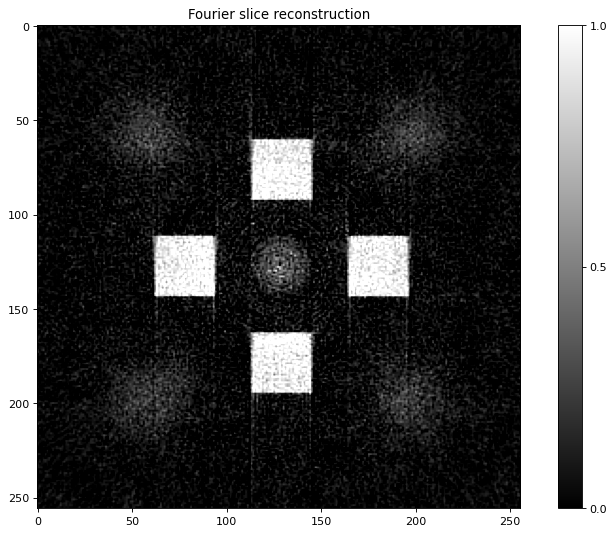

In [20]:
# initialise tomobar DIRECT reconstruction class ONCE
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'cpu')

print ("Reconstruction using FBP from tomobar")
recNumerical= RectoolsDIR.FOURIER(projData3D_norm[sliceSel,:,:])
recNumerical *= intens_max_clean

plt.figure() 
plt.imshow(recNumerical, vmin=0, vmax=1, cmap="gray")
plt.colorbar(ticks=[0, 0.5, 1], orientation='vertical')
plt.title('Fourier slice reconstruction')